In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install keras --upgrade

In [ ]:
!pip install pymannkendall

In [ ]:
import warnings
warnings.filterwarnings("ignore")
#Importing Libraries for  data manipulation and analysis and support for large, multi-dimensional arrays and matrices
import numpy as np
import pandas as pd

#Importing Libraries for data visualizaion
from matplotlib import pyplot as plt
import seaborn as sns

#Importing Libraries for ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Import seasonal decompose
from statsmodels.tsa.seasonal import seasonal_decompose

#Importing Libraries for seasonality and trend test
from scipy.stats import kruskal
import pymannkendall as mk

#Importing Statistical Models for Timeseries
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Importing LSTM layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

#Importing metric library
from sklearn.metrics import mean_squared_error

#Importing library to dump final model
import joblib

## **Importing Uneployment Data**

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Capstone Merge 1 - Copy.xlsx")

## **Data Preprocessing**

In [ ]:
df.sort_values("Date", inplace=True)
df = df.set_index('Date')
df = df.drop(["Employement Rate"], axis=1)
df.head()

,Min wage,GDP,USD,Oil Price,CPI,Unemployement Rate
Date,,,,,,
2000-04-01,11.70,1335504,0.681610,24.46,94.4,6.0
2000-05-01,11.70,1343064,0.669530,27.08,94.7,5.4
2000-06-01,11.77,1348065,0.676916,29.93,95.3,5.2
2000-07-01,11.82,1351075,0.676913,30.00,95.6,5.6
2000-08-01,11.80,1356048,0.674726,28.87,95.5,6.2


##**EDA**

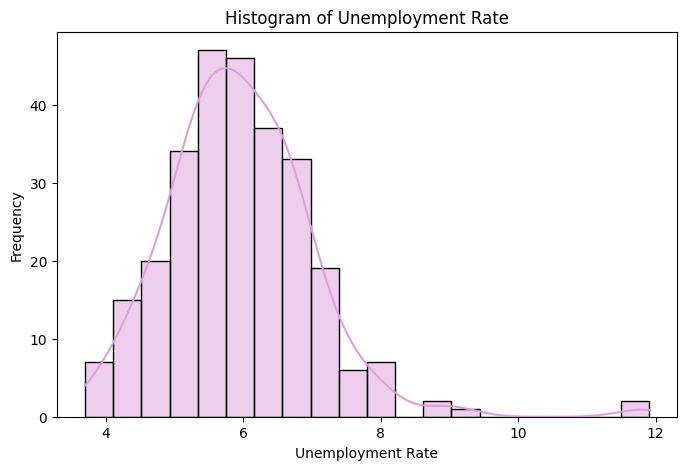

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Unemployement Rate'], bins=20, kde=True, color='plum')
plt.title('Histogram of Unemployment Rate')
plt.xlabel('Unemployment Rate')
plt.ylabel('Frequency')
plt.show()

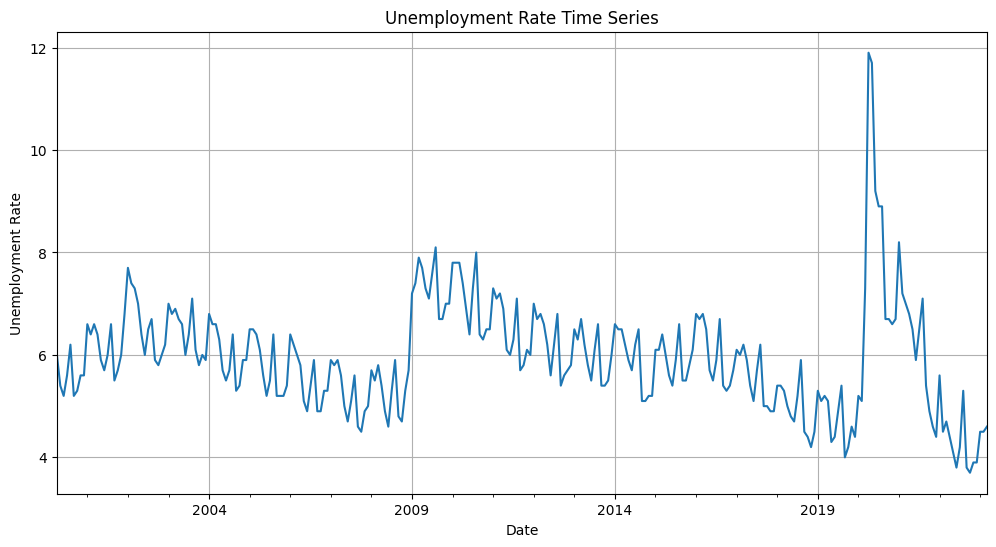

In [ ]:
# Plot the Unemployment Rate time series
plt.figure(figsize=(12, 6))
df['Unemployement Rate'].plot()
plt.title('Unemployment Rate Time Series')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.grid(True)
plt.show()

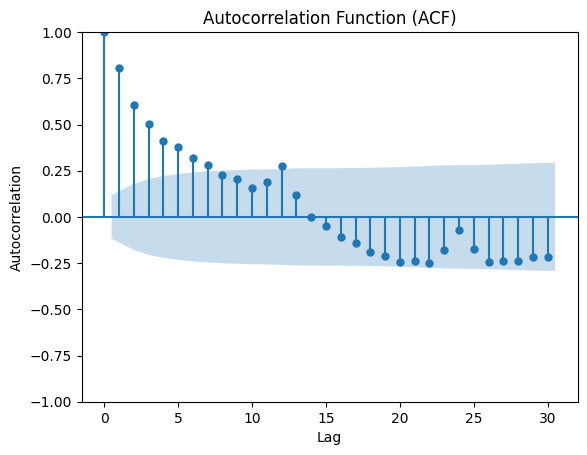

In [ ]:
# Plot Autocorrelation Function (ACF)
plot_acf(df['Unemployement Rate'], lags=30)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()
# Looking at the ACF the q value is between 5 and 8

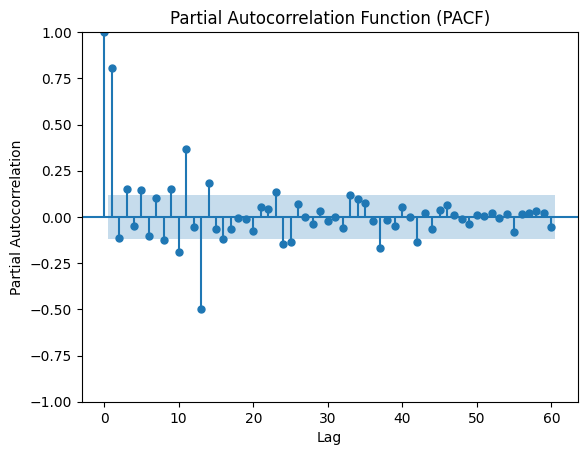

In [ ]:
# Plot Partial Autocorrelation Function (PACF)
plot_pacf(df['Unemployement Rate'], lags=60)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()
#Looking at PACF p value should be between 2,11,13

In [ ]:
# Perform ADF test
def adf_test(timeseries):
    # Perform Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [ ]:
adf_test(df['Unemployement Rate'].dropna())

ADF Statistic: -3.471529174602234
p-value: 0.008749108776928744
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


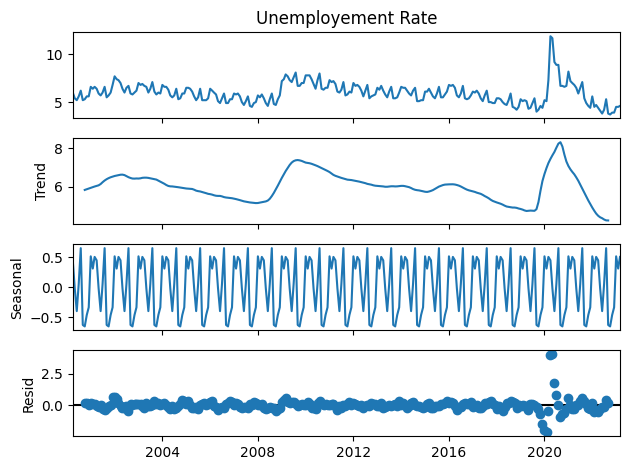

In [ ]:
# Perform additive decomposition
decomp = seasonal_decompose(df['Unemployement Rate'],
                            period=12)

# Plot decomposition
decomp.plot()
plt.show()
# Here we can see the seasonality and trend

In [ ]:
def seasonality_test(series):
        seasonal = False
        idx = np.arange(len(series.index)) % 12
        H_statistic, p_value = kruskal(series, idx)
        if p_value <= 0.05:
            seasonal = True
        return seasonal


In [ ]:
print("Seasonality Test: ",seasonality_test(df["Unemployement Rate"]))
print("Trend Test: ",mk.original_test(df["Unemployement Rate"]))

Seasonality Test:  False
Trend Test:  Mann_Kendall_Test(trend='decreasing', h=True, p=2.1243123429215416e-06, z=-4.74122368506292, Tau=-0.1913570487483531, s=-7262.0, var_s=2345373.3333333335, slope=-0.0035971223021582736, intercept=6.394604316546763)


In [ ]:
stationary_data =  df['Unemployement Rate'].diff().diff()
adf_test(stationary_data.dropna())
#After doing differencing twice we have achieved stationary data which means D =2

ADF Statistic: -8.690132392463623
p-value: 4.061715563357034e-14
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


In [ ]:
print("Seasonality Test: ",seasonality_test(stationary_data))
print("Trend Test: ",mk.original_test(stationary_data))


Seasonality Test:  False
Trend Test:  Mann_Kendall_Test(trend='no trend', h=False, p=0.7725694893763586, z=0.2890155350489766, Tau=0.011737654073420497, s=439.0, var_s=2296708.3333333335, slope=0.0, intercept=0.09999999999999964)


<Axes: xlabel='Date'>

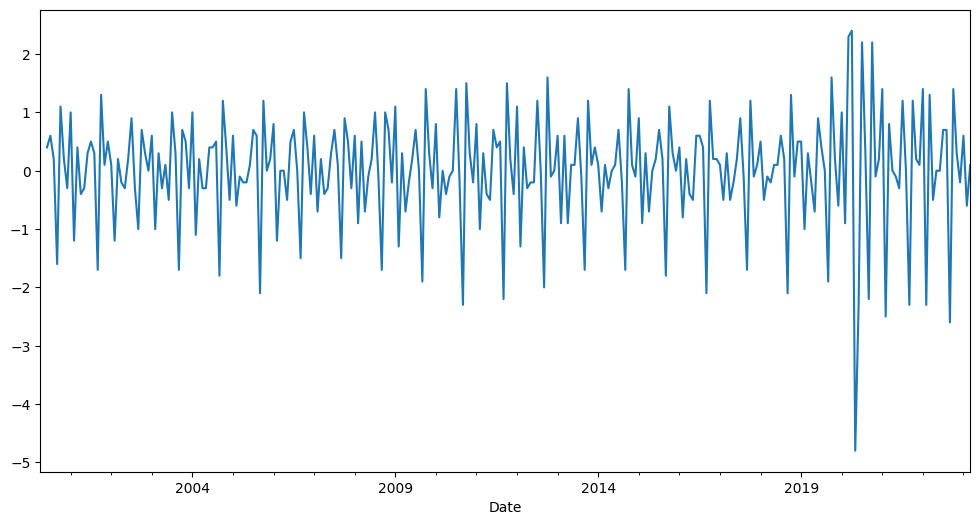

In [ ]:
plt.figure(figsize=(12, 6))
stationary_data.plot()

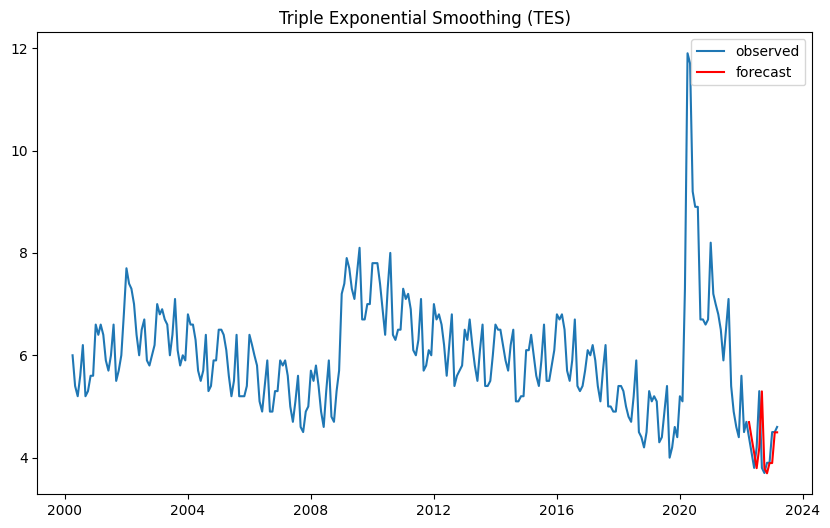

In [ ]:
# Fit the TES model
tes_model = ExponentialSmoothing(df['Unemployement Rate'], trend='add') #, seasonal='add', seasonal_periods=12
tes_result = tes_model.fit()


# Get the fitted values
preds = tes_result.predict(start = df.index[-12], end = df.index[-1])
preds
# Plot original data and fitted values
plt.figure(figsize=(10, 6))
plt.plot(df.index, df["Unemployement Rate"], label='observed')
# plot your mean predictions
plt.plot(preds.index, preds, color='r', label='forecast')

plt.title('Triple Exponential Smoothing (TES)')
plt.legend()
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(df["Unemployement Rate"][-12:], preds))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.5992559397934761


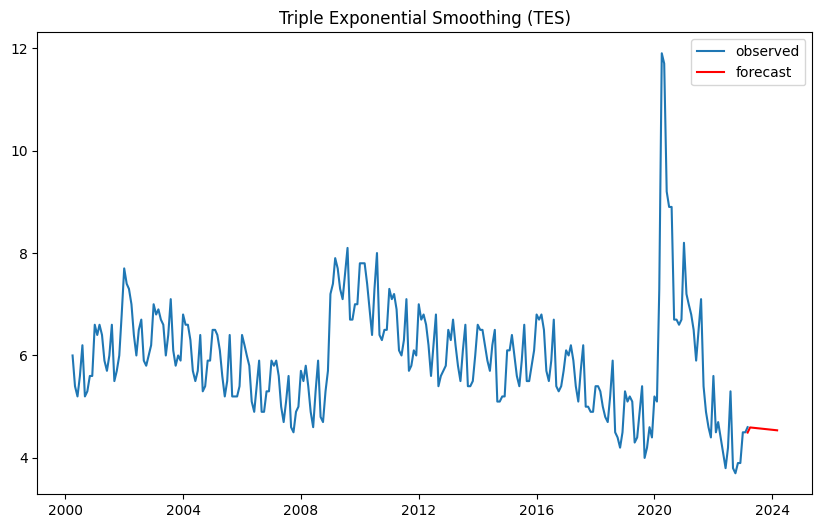

In [ ]:
preds = tes_result.predict(start = df.index[-1], end = df.index[-1]+np.timedelta64(12, 'M'))
preds
# Plot original data and fitted values
plt.figure(figsize=(10, 6))
plt.plot(df.index, df["Unemployement Rate"], label='observed')
# plot your mean predictions
plt.plot(preds.index, preds, color='r', label='forecast')

plt.title('Triple Exponential Smoothing (TES)')
plt.legend()
plt.show()

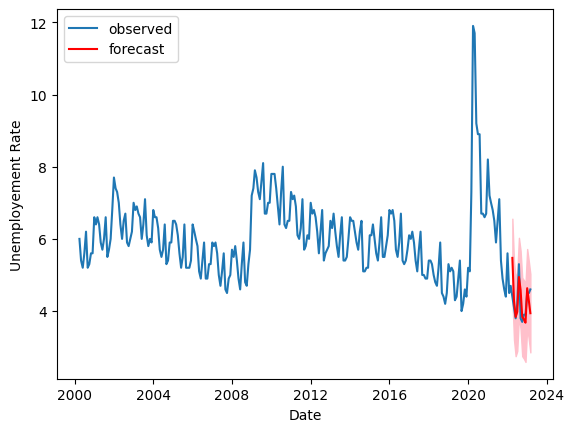

In [ ]:
# Fit ARIMA model
model = ARIMA(df['Unemployement Rate'], order=(2, 2,8))
arima_result = model.fit()
arima_result.summary()
preds= arima_result.get_prediction(start=-12)
mean_forecast = preds.predicted_mean
# Get confidence intervals of predictions
confidence_intervals = preds.conf_int()

lower_limits = confidence_intervals.loc[:,'lower Unemployement Rate']
upper_limits = confidence_intervals.loc[:,'upper Unemployement Rate']
plt.plot(df.index, df["Unemployement Rate"], label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits,
                upper_limits, color='pink')

#set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Unemployement Rate')
plt.legend()
plt.show()

In [ ]:
order_aic_bic=[]
# Loop over p values from 0-2
for p in range(13):
# Loop over q values from 0-2
    for q in range(8):
        try:
            # Create and fit ARIMA(p,d,q) model
            model = ARIMA(df["Unemployement Rate"], order=(p,2,q))
            results = model.fit()
            # Append order and results tuple
            order_aic_bic.append((p,q,results.aic, results.bic))
        except:
            print(p, q, None, None)
#%%
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic,
                        columns=['p', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC').head(5))

# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC').head(5))

      p  q         AIC         BIC
79    9  7  367.777751  429.200929
71    8  7  368.457170  426.267220
94   11  6  369.237138  434.273444
95   11  7  369.327650  437.977084
103  12  7  370.099275  442.361837
     p  q         AIC         BIC
71   8  7  368.457170  426.267220
79   9  7  367.777751  429.200929
94  11  6  369.237138  434.273444
93  11  5  374.796588  436.219766
95  11  7  369.327650  437.977084


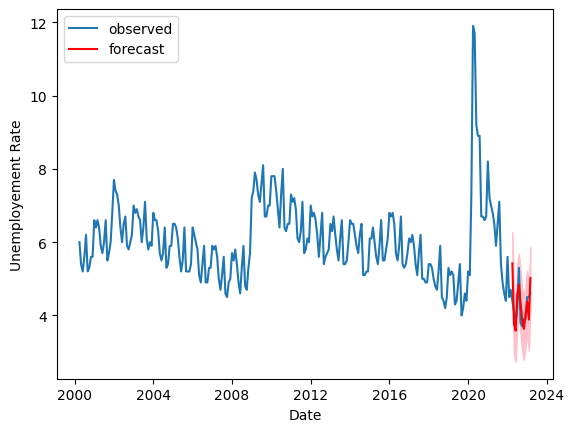

In [ ]:
model = ARIMA(df['Unemployement Rate'], order=(8, 2,7))
arima_result = model.fit()
arima_result.summary()
preds= arima_result.get_prediction(start=-12)
mean_forecast = preds.predicted_mean
# Get confidence intervals of predictions
confidence_intervals = preds.conf_int()

lower_limits = confidence_intervals.loc[:,'lower Unemployement Rate']
upper_limits = confidence_intervals.loc[:,'upper Unemployement Rate']
plt.plot(df.index, df["Unemployement Rate"], label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits,
                upper_limits, color='pink')

#set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Unemployement Rate')
plt.legend()
plt.show()

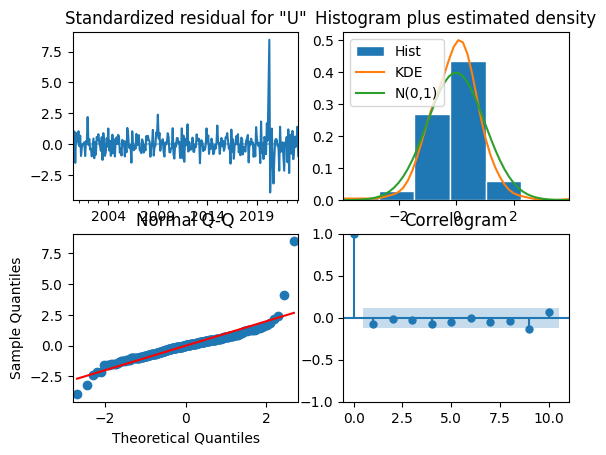

In [ ]:
arima_result.plot_diagnostics()
plt.show()

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(df["Unemployement Rate"][-12:], mean_forecast))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.45598896065547967


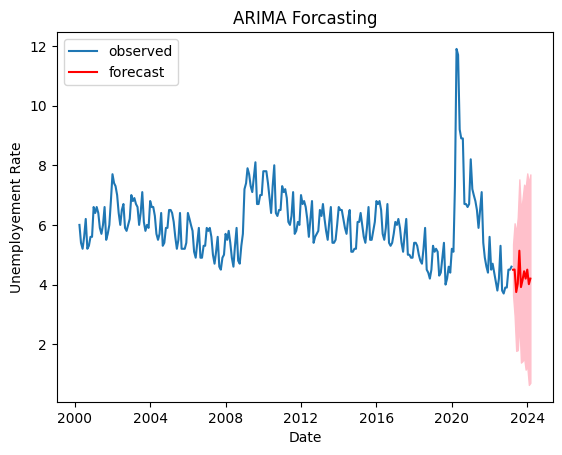

In [ ]:
# Forcast for next 12 months

forecast = arima_result.get_forecast(steps =12)
mean_forecast= forecast.predicted_mean
confidence_intervals= forecast.conf_int()
confidence_intervals
# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower Unemployement Rate']
upper_limits = confidence_intervals.loc[:,'upper Unemployement Rate']

# plot the  data
plt.plot(df.index, df["Unemployement Rate"], label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits,
               upper_limits, color='pink')

# set labels, legends and show plot
plt.title('ARIMA Forcasting')
plt.xlabel('Date')
plt.ylabel('Unemployement Rate')
plt.legend()
plt.show()

In [ ]:
trainlen = int(len(df)*0.75)
train_df,test_df = df[:trainlen], df[trainlen:]

In [ ]:
# test_df.to_csv("/content/drive/MyDrive/TestData.csv")

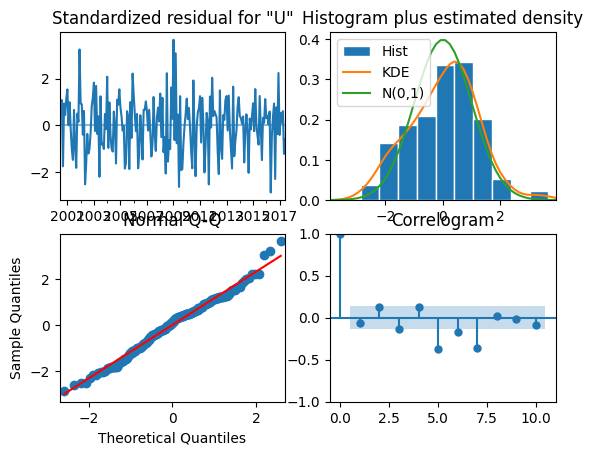

Root Mean Squared Error (RMSE): 2.26535584394451


In [ ]:
serimaxModel = SARIMAX(train_df["Unemployement Rate"], order=(8, 2,7), exog = train_df[['Min wage', 'GDP', 'USD', 'Oil Price', 'CPI']].to_numpy())
serimaxmodelResult = serimaxModel.fit()
pred = serimaxmodelResult.predict(start= df.index[trainlen], end=df.index[-1], exog=test_df[['Min wage', 'GDP', 'USD', 'Oil Price', 'CPI']].to_numpy())
serimaxmodelResult.plot_diagnostics()
plt.show()
rmse = np.sqrt(mean_squared_error(df["Unemployement Rate"][trainlen:], pred))
print("Root Mean Squared Error (RMSE):", rmse)

In [ ]:
order_aic_bic=[]
# Loop over p values from 0-2
for p in range(13):
# Loop over q values from 0-2
    for q in range(8):
        try:
            # Create and fit ARIMA(p,d,q) model
            model = SARIMAX(train_df["Unemployement Rate"], order=(p, 2,q), exog = train_df[['Min wage', 'GDP', 'USD', 'Oil Price', 'CPI']].to_numpy())
            results = model.fit()
            # Append order and results tuple
            order_aic_bic.append((p,q,results.aic, results.bic))
        except:
            print(p, q, None, None)

#%%
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic,
                        columns=['p', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC'))

# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

      p  q          AIC          BIC
88   11  0    68.438507   124.929677
94   11  6    70.761541   147.190770
96   12  0    71.437120   131.251300
95   11  7    95.072879   174.825119
103  12  7    96.593110   179.668359
..   .. ..          ...          ...
98   12  2  1500.561463  1567.021662
90   11  2  1505.019058  1568.156248
85   10  5  1632.135814  1701.919023
93   11  5  1634.135814  1707.242033
102  12  6  1731.392164  1811.144403

[104 rows x 4 columns]
      p  q          AIC          BIC
88   11  0    68.438507   124.929677
96   12  0    71.437120   131.251300
94   11  6    70.761541   147.190770
95   11  7    95.072879   174.825119
103  12  7    96.593110   179.668359
..   .. ..          ...          ...
98   12  2  1500.561463  1567.021662
90   11  2  1505.019058  1568.156248
85   10  5  1632.135814  1701.919023
93   11  5  1634.135814  1707.242033
102  12  6  1731.392164  1811.144403

[104 rows x 4 columns]


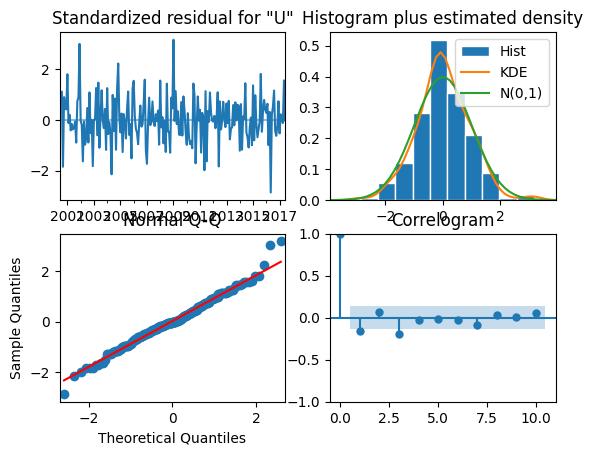

Root Mean Squared Error (RMSE): 1.349458551067733


In [ ]:
serimaxModel = SARIMAX(train_df["Unemployement Rate"], order=(11, 2,0), exog = train_df[['Min wage', 'GDP', 'USD', 'Oil Price', 'CPI']].to_numpy())
serimaxmodelResult = serimaxModel.fit()
pred = serimaxmodelResult.get_prediction(start= df.index[trainlen], end=df.index[-1], exog=test_df[['Min wage', 'GDP', 'USD', 'Oil Price', 'CPI']].to_numpy())
confidence_intervals = pred.conf_int()
mean_forecast = pred.predicted_mean
serimaxmodelResult.plot_diagnostics()
plt.show()
rmse = np.sqrt(mean_squared_error(test_df["Unemployement Rate"], mean_forecast))
print("Root Mean Squared Error (RMSE):", rmse)

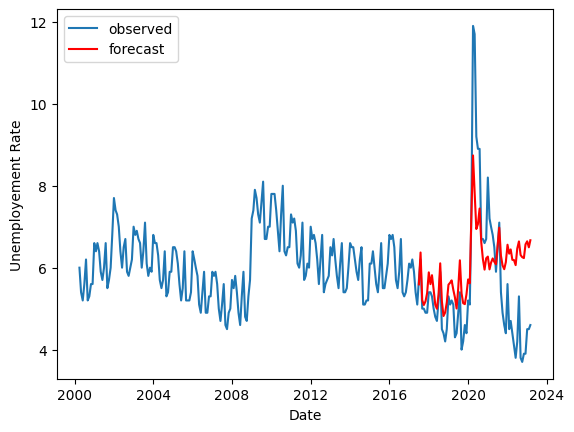

In [ ]:
lower_limits = confidence_intervals.loc[:,'lower Unemployement Rate']
upper_limits = confidence_intervals.loc[:,'upper Unemployement Rate']
plt.plot(df.index, df["Unemployement Rate"], label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
#plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

#set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Unemployement Rate')
plt.legend()
plt.show()

To Normalise the data including target variable

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(train_df)
df_for_testing_scaled=scaler.transform(test_df)

In [ ]:
joblib.dump(scaler,"/content/drive/MyDrive/unemploymentPredictionScaler.joblib")

['/content/drive/MyDrive/unemploymentPredictionScaler.joblib']

In [ ]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    # This for loop will loop from n_past = 3 till len(dataset) = 204
    for i in range(n_past, len(dataset)):
        #This will give array of dataframe with 3 window for predicting
        dataX.append(dataset[i - n_past:i, 0:-1])
        dataY.append(dataset[i,-1])
    return np.array(dataX),np.array(dataY)
trainX,trainY=createXY(df_for_training_scaled,3)
testX,testY=createXY(df_for_testing_scaled,3)

In [ ]:
trainX.shape

(204, 3, 5)

In [ ]:
import keras
model = Sequential()
model.add(LSTM(60,input_shape=(3,5)))
# model.add(LSTM(60))
model.add(Dense(60))
model.add(Dropout(0.5))
model.add(Dense(30))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0012), loss='mse')

# Train the model
model.fit(trainX,trainY, epochs=40, batch_size=3, verbose=1)

# Evaluate the model
mse = model.evaluate(testX,testY)
print("Mean Squared Error:", mse)

Epoch 1/40
68/68 [==============================] - 5s 7ms/step - loss: 0.0833
Epoch 2/40
68/68 [==============================] - 0s 6ms/step - loss: 0.0515
Epoch 3/40
68/68 [==============================] - 0s 7ms/step - loss: 0.0501
Epoch 4/40
68/68 [==============================] - 0s 6ms/step - loss: 0.0455
Epoch 5/40
68/68 [==============================] - 0s 6ms/step - loss: 0.0423
Epoch 6/40
68/68 [==============================] - 0s 6ms/step - loss: 0.0403
Epoch 7/40
68/68 [==============================] - 0s 6ms/step - loss: 0.0440
Epoch 8/40
68/68 [==============================] - 0s 6ms/step - loss: 0.0362
Epoch 9/40
68/68 [==============================] - 0s 6ms/step - loss: 0.0363
Epoch 10/40
68/68 [==============================] - 0s 6ms/step - loss: 0.0324
Epoch 11/40
68/68 [==============================] - 0s 6ms/step - loss: 0.0323
Epoch 12/40
68/68 [==============================] - 0s 6ms/step - loss: 0.0354
Epoch 13/40
68/68 [==============================

In [ ]:
prediction=model.predict(testX)
# print("prediction\n", prediction)
# print("\nPrediction Shape-",prediction.shape)

3/3 [==============================] - 0s 6ms/step


In [ ]:
# scaler.inverse_transform(prediction)

In [ ]:
prediction_copies_array = np.repeat(prediction,6, axis=-1)

In [ ]:
prediction_copies_array.shape

(66, 6)

In [ ]:
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),6)))[:,5]

In [ ]:
original_copies_array = np.repeat(testY,6, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),6)))[:,5]

In [ ]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- " ,original)

Pred Values--  [5.361816  5.406293  5.4291306 5.274421  5.1636043 5.1286335 5.137509
 5.1232357 5.049512  5.053005  4.9865165 4.984753  4.986648  4.9356084
 5.025707  5.080299  5.094702  5.115163  5.081825  4.9867725 4.8538017
 4.7606463 4.7233605 4.7552276 4.7557554 4.7394614 4.806066  4.810505
 4.769916  4.7119427 5.15919   6.509075  8.577672  9.773467  8.383791
 7.111465  6.5221934 6.3150907 6.238364  6.1931486 6.132473  6.1634994
 6.227173  6.2043    6.100044  6.3105803 6.280216  5.9521008 5.793435
 5.6837335 5.656312  5.4772024 5.4275675 5.496139  5.479971  5.389101
 5.3107815 5.400062  5.3764205 5.4018455 5.388359  5.4140244 5.380348
 5.3395305 5.2645    5.2324195]

Original Values--  [ 5.   4.9  4.9  5.4  5.4  5.3  5.   4.8  4.7  5.2  5.9  4.5  4.4  4.2
  4.5  5.3  5.1  5.2  5.1  4.3  4.4  4.9  5.4  4.   4.2  4.6  4.4  5.2
  5.1  7.3 11.9 11.7  9.2  8.9  8.9  6.7  6.7  6.6  6.7  8.2  7.2  7.
  6.8  6.5  5.9  6.5  7.1  5.4  4.9  4.6  4.4  5.6  4.5  4.7  4.4  4.1
  3.8  4.2  5.3  

In [ ]:
pred = pd.Series(pred, index = df.index[trainlen+3:])
pred.head()

Date
2017-10-01    5.361816
2017-11-01    5.406293
2017-12-01    5.429131
2018-01-01    5.274421
2018-02-01    5.163604
dtype: float32

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(df["Unemployement Rate"][trainlen+3:], pred))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 1.33335397681644


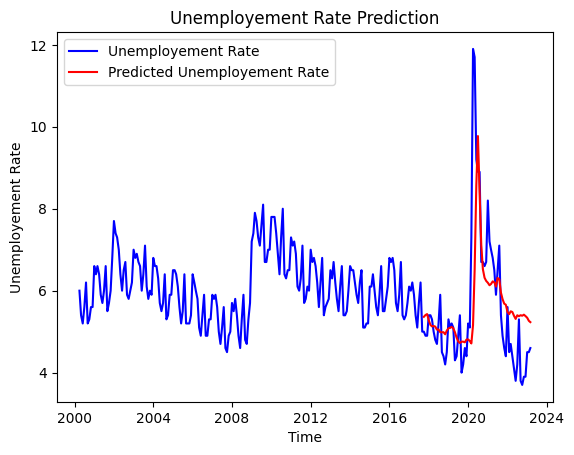

In [ ]:
plt.plot(df["Unemployement Rate"], color = 'blue', label = 'Unemployement Rate')
plt.plot(pred, color = 'red', label = 'Predicted Unemployement Rate')
plt.title('Unemployement Rate Prediction')
plt.xlabel('Time')
plt.ylabel('Unemployement Rate')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import  load_model
model.save('/content/drive/MyDrive/finalmodel.h5', save_format='tf')
# m = load_model('model.h5')